# 4. SED Fitting to Derive the Global Properties of Galaxies

In this step, we will perform spectral energy distribution (SED) fitting using [piXedfit](https://github.com/aabdurrouf/piXedfit) to measure the global (i.e., integrated) stellar population properties of high redshift galaxies. In this example, we will focus on galaxies at redshift range of 4.0<z<5.0 from both cropped regions.  

In [1]:
import os, sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 4.1. Select Galaxies and make input photometric data for piXedfit

In this step, we select galaxies at 4.0<z<5.0 from cropped region 1 and 2, then store them into new text files, which will then be inputted to piXedfit for SED fitting and measuring their properties.

In [2]:
# selecting galaxies at 4.0<z<5.0 in cropped region 1
data1 = np.loadtxt('ceers_crop1_photo_pz.cat')
idx1 = np.where((data1[:,17]>4.0) & (data1[:,17]<5.0))
ngals_crop1 = len(idx1[0])
print ("Number of galaxies selected in region 1: %d" % ngals_crop1)

# selecting galaxies at 4.0<z<5.0 in cropped region 2
data2 = np.loadtxt('ceers_crop2_photo_pz.cat')
idx2 = np.where((data2[:,17]>4.0) & (data2[:,17]<5.0))
ngals_crop2 = len(idx2[0])
print ("Number of galaxies selected in region 2: %d" % ngals_crop2)

#==> put into text file: to be inputted to piXedfit
file_out = open('ceers_crop1_photo_pz_4z5.cat','w')
file_out.write("#(1)id (2)x (3)y (4)ra (5)dec (6)f_f115w (7)e_f115w (8)f_f150w (9)e_f150w (10)f_f200w (11)e_f200w (12)f_f277w (13)e_f277w (14)f_f356w (15)e_f356w (16)f_f444w (17)e_f444w (18)photo-z (20)photo-z chi2\n")
file_out.write("# All flux densisties are in units of erg/s/cm^2/Angstrom\n")
for ii in idx1[0]:
    file_out.write("%d " % data1[ii][0])
    for xx in range (1,data1.shape[1]-1):
        file_out.write("%e " % data1[ii][xx])
    file_out.write("%e\n" % data1[ii][data1.shape[1]-1])
file_out.close()
        

#==> put into text file: to be inputted to piXedfit
file_out = open('ceers_crop2_photo_pz_4z5.cat','w')
file_out.write("#(1)id (2)x (3)y (4)ra (5)dec (6)f_f115w (7)e_f115w (8)f_f150w (9)e_f150w (10)f_f200w (11)e_f200w (12)f_f277w (13)e_f277w (14)f_f356w (15)e_f356w (16)f_f444w (17)e_f444w (18)photo-z (20)photo-z chi2\n")
file_out.write("# All flux densisties are in units of erg/s/cm^2/Angstrom\n")
for ii in idx2[0]:
    file_out.write("%d " % data2[ii][0])
    for xx in range (1,data2.shape[1]-1):
        file_out.write("%e " % data2[ii][xx])
    file_out.write("%e\n" % data2[ii][data1.shape[1]-1])
file_out.close()


Number of galaxies selected in region 1: 36
Number of galaxies selected in region 2: 34


## 4.2. Generate model spectra at rest-frame

Script below can be used to generate model spectra at rest-frame. The `save_models_rest_spec` function implements MPI for parallel computation. The script below uses 20 cores (can be changed), therefore it is recommended to execute this script on a cluster.  

In [ ]:
from astropy.cosmology import *

from piXedfit.piXedfit_model import save_models_rest_spec

imf_type = 1                    # Chabrier (2003)
sfh_form = 4                    # double power law SFH form
dust_law = 0                    # Charlot & Fall (2000) dust attenuation law
duste_switch = 0                # turn off dust emission
add_neb_emission = 1            # turn on nebular emission
add_agn = 0                     # turn off AGN dusty torus emission

nmodels = 70000                 # number of models to be generated
nproc = 20                      # number of cores (processors) to be used in calculations 

max_z = 4.0                     # lowest redshift

cosmo1 = FlatLambdaCDM(H0=70.0, Om0=0.3)
age_univ = cosmo1.age(max_z)
max_log_age = np.log10(age_univ.value)

params_range = {'dust1':[0.0,3.0], 'dust2':[0.0,3.0], 'log_age':[-1.0,max_log_age], 
                'log_alpha':[-2.0,2.0], 'log_beta':[-2.0,2.0]}

name_out = 'model_specs_restframe.hdf5'
save_models_rest_spec(imf_type=imf_type, sfh_form=sfh_form, dust_law=dust_law, params_range=params_range,
                        duste_switch=duste_switch, add_neb_emission=add_neb_emission, add_agn=add_agn,
                        nmodels=nmodels, nproc=nproc, name_out=name_out)

## 4.3. Run SED fitting

### SED fitting for galaxies in cropped region 1

In [ ]:
from piXedfit.piXedfit_fitting import singleSEDfit
from piXedfit.piXedfit_fitting import priors

# set of filters
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']
nbands = len(filters)

# index of fluxes in the catalog
idx_flux = np.asarray([5, 7, 9, 11, 13, 15])
idx_flux = idx_flux.astype(int)
# index of flux errors in the catalog
idx_flux_err = np.asarray([6, 8, 10, 12, 14, 16])
idx_flux_err = idx_flux_err.astype(int)

# model spectra at rest-frame
models_spec = 'model_specs_restframe.hdf5'

# fitting method
fit_method = 'mcmc'

nproc = 20 

# open the photometric data
data = np.loadtxt('ceers_crop1_photo_pz_4z5.cat')
    
for ii in range(0,ngals_crop1):
    # get the SED
    obs_flux = data[ii][idx_flux]
    obs_flux_err = data[ii][idx_flux_err]
    
    # get photometric redshift
    gal_z = data[ii][17]
    
    # define prior for redshift
    ranges = {'z':[gal_z-0.3,gal_z+0.3]}
    pr = priors(ranges)
    params_ranges = pr.params_ranges()
    
    prior1 = pr.gaussian('z',gal_z,0.2)
    params_priors = [prior1]
    
    # name of output FITS file:
    name_out_fits = 'mcmc_crop1_%d.fits' % data[ii][0]
    singleSEDfit(obs_flux, obs_flux_err, filters, models_spec, params_ranges=params_ranges, 
             params_priors=params_priors, fit_method=fit_method, gal_z=None, nrands_z=20, 
             add_igm_absorption=1, igm_type=1, nwalkers=100, nsteps=600, nproc=nproc, initfit_nmodels_mcmc=30000, 
             store_full_samplers=1, name_out_fits=name_out_fits)


### SED fitting for galaxies in cropped region 2

In [ ]:
from piXedfit.piXedfit_fitting import singleSEDfit
from piXedfit.piXedfit_fitting import priors

# set of filters
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']
nbands = len(filters)

# index of fluxes in the catalog
idx_flux = np.asarray([5, 7, 9, 11, 13, 15])
idx_flux = idx_flux.astype(int)
# index of flux errors in the catalog
idx_flux_err = np.asarray([6, 8, 10, 12, 14, 16])
idx_flux_err = idx_flux_err.astype(int)

# model spectra at rest-frame
models_spec = 'model_specs_restframe.hdf5'

# fitting method
fit_method = 'mcmc'

nproc = 20 

# open the photometric data
data = np.loadtxt('ceers_crop2_photo_pz_4z5.cat')
    
for ii in range(0,ngals_crop2):
    # get the SED
    obs_flux = data[ii][idx_flux]
    obs_flux_err = data[ii][idx_flux_err]
    
    # get photometric redshift
    gal_z = data[ii][17]
    
    # define prior for redshift
    ranges = {'z':[gal_z-0.3,gal_z+0.3]}
    pr = priors(ranges)
    params_ranges = pr.params_ranges()
    
    prior1 = pr.gaussian('z',gal_z,0.2)
    params_priors = [prior1]
    
    # name of output FITS file:
    name_out_fits = 'mcmc_crop2_%d.fits' % data[ii][0]
    singleSEDfit(obs_flux, obs_flux_err, filters, models_spec, params_ranges=params_ranges, 
             params_priors=params_priors, fit_method=fit_method, gal_z=None, nrands_z=20, 
             add_igm_absorption=1, igm_type=1, nwalkers=100, nsteps=600, nproc=nproc, initfit_nmodels_mcmc=30000, 
             store_full_samplers=1, name_out_fits=name_out_fits)


## 4.4. Check fitting results: make diagnostics plots

In [3]:
from piXedfit.piXedfit_analysis import plot_corner
from piXedfit.piXedfit_analysis import plot_SED
from piXedfit.piXedfit_analysis import plot_sfh_mcmc

Plotting posteriors probability distributions
=> Number of parameters: 8


'corner_mcmc_crop1_95.png'

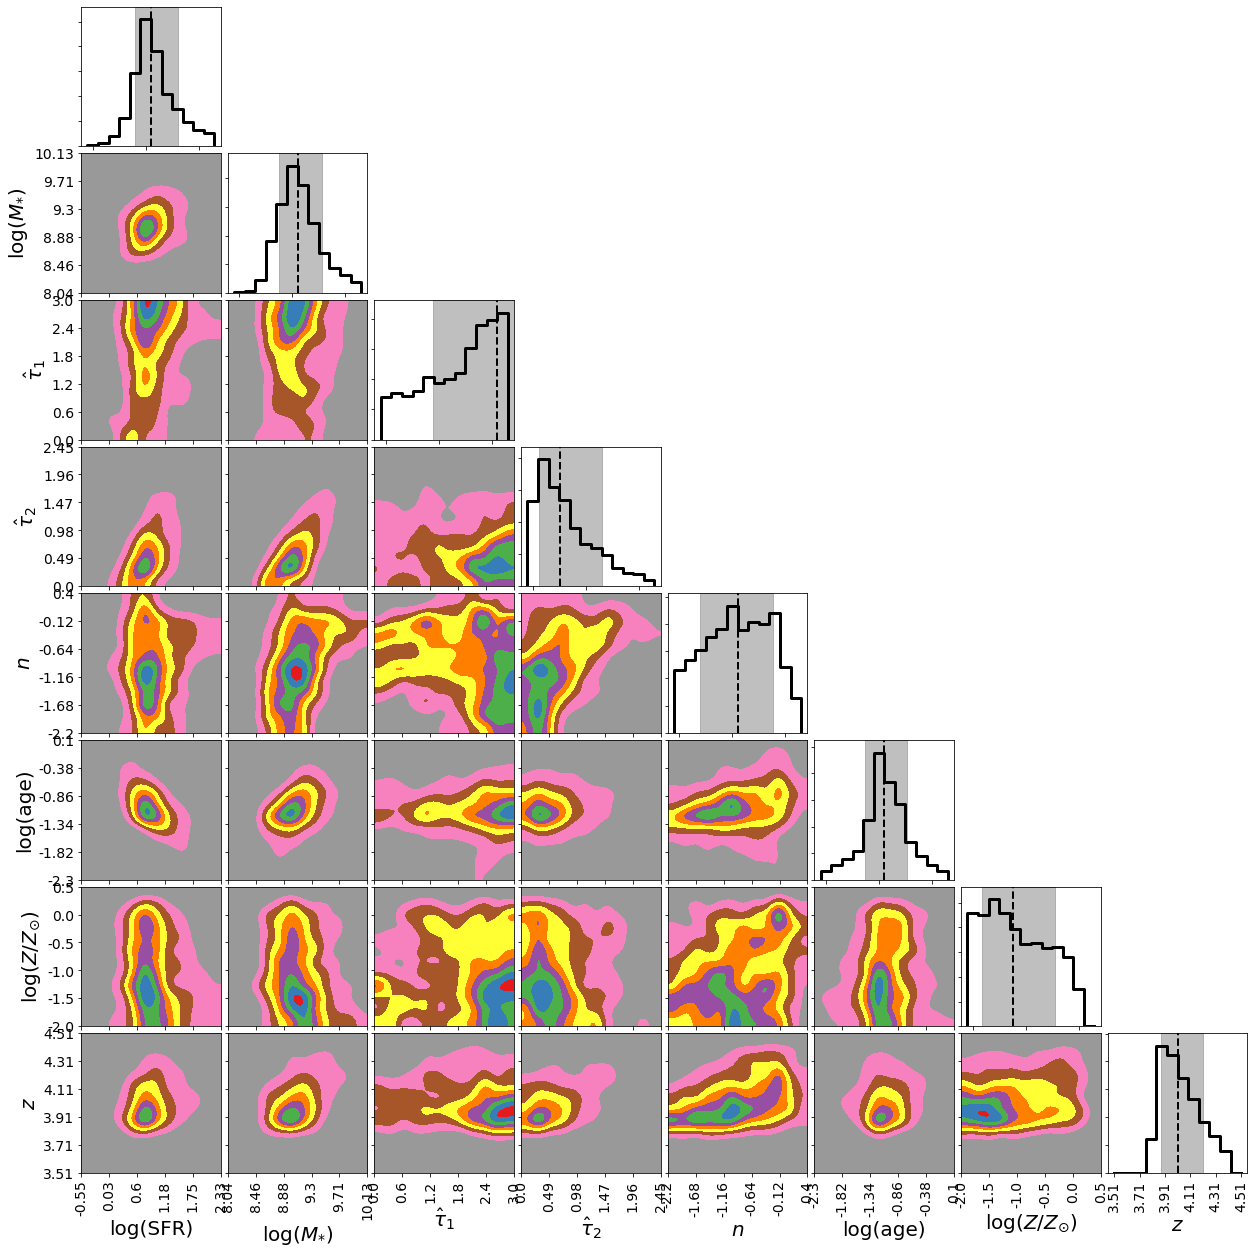

In [44]:
%matplotlib inline

name_sampler_fits = 'mcmc_crop1_95.fits'

params=['log_sfr', 'log_mass',  'dust1', 'dust2', 'dust_index', 'log_mw_age', 'logzsol', 'z']
label_params={'dust1': '$\\hat \\tau_{1}$', 'dust2': '$\\hat \\tau_{2}$', 'dust_index': '$n$', 
              'log_mass': 'log($M_{*}$)', 'log_mw_age': 'log(age)', 'log_sfr': 'log(SFR)', 
              'logzsol': 'log($Z/Z_{\\odot}$)', 'z':'$z$'}

plot_corner(name_sampler_fits, params=params, label_params=label_params)

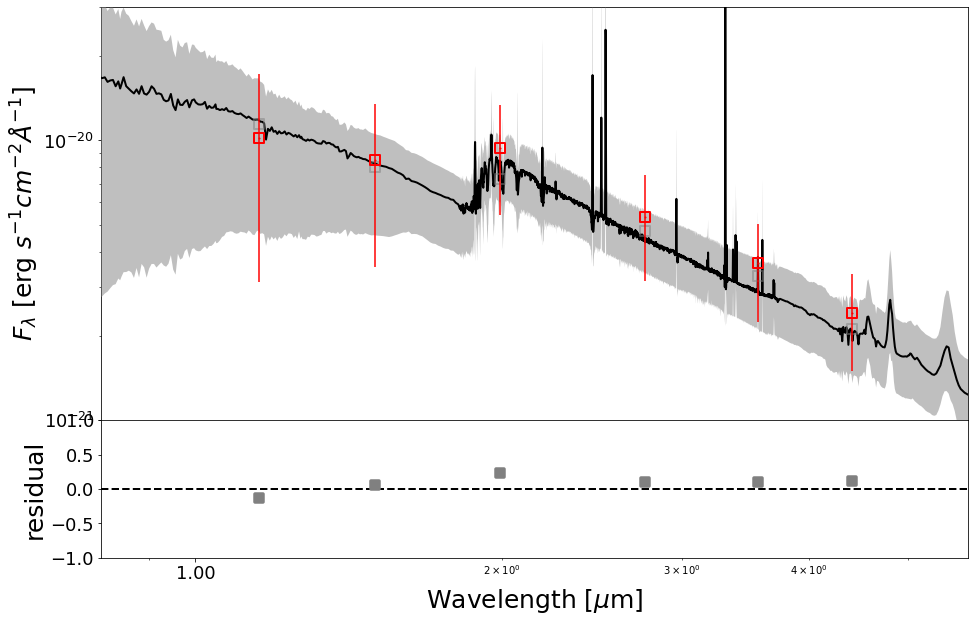

In [46]:
name_sampler_fits = 'mcmc_crop1_95.fits'
plot_SED(name_sampler_fits, decompose=0, yrange=[1e-21,3e-20])

Plotting posteriors probability distributions
=> Number of parameters: 8


'corner_mcmc_crop2_33.png'

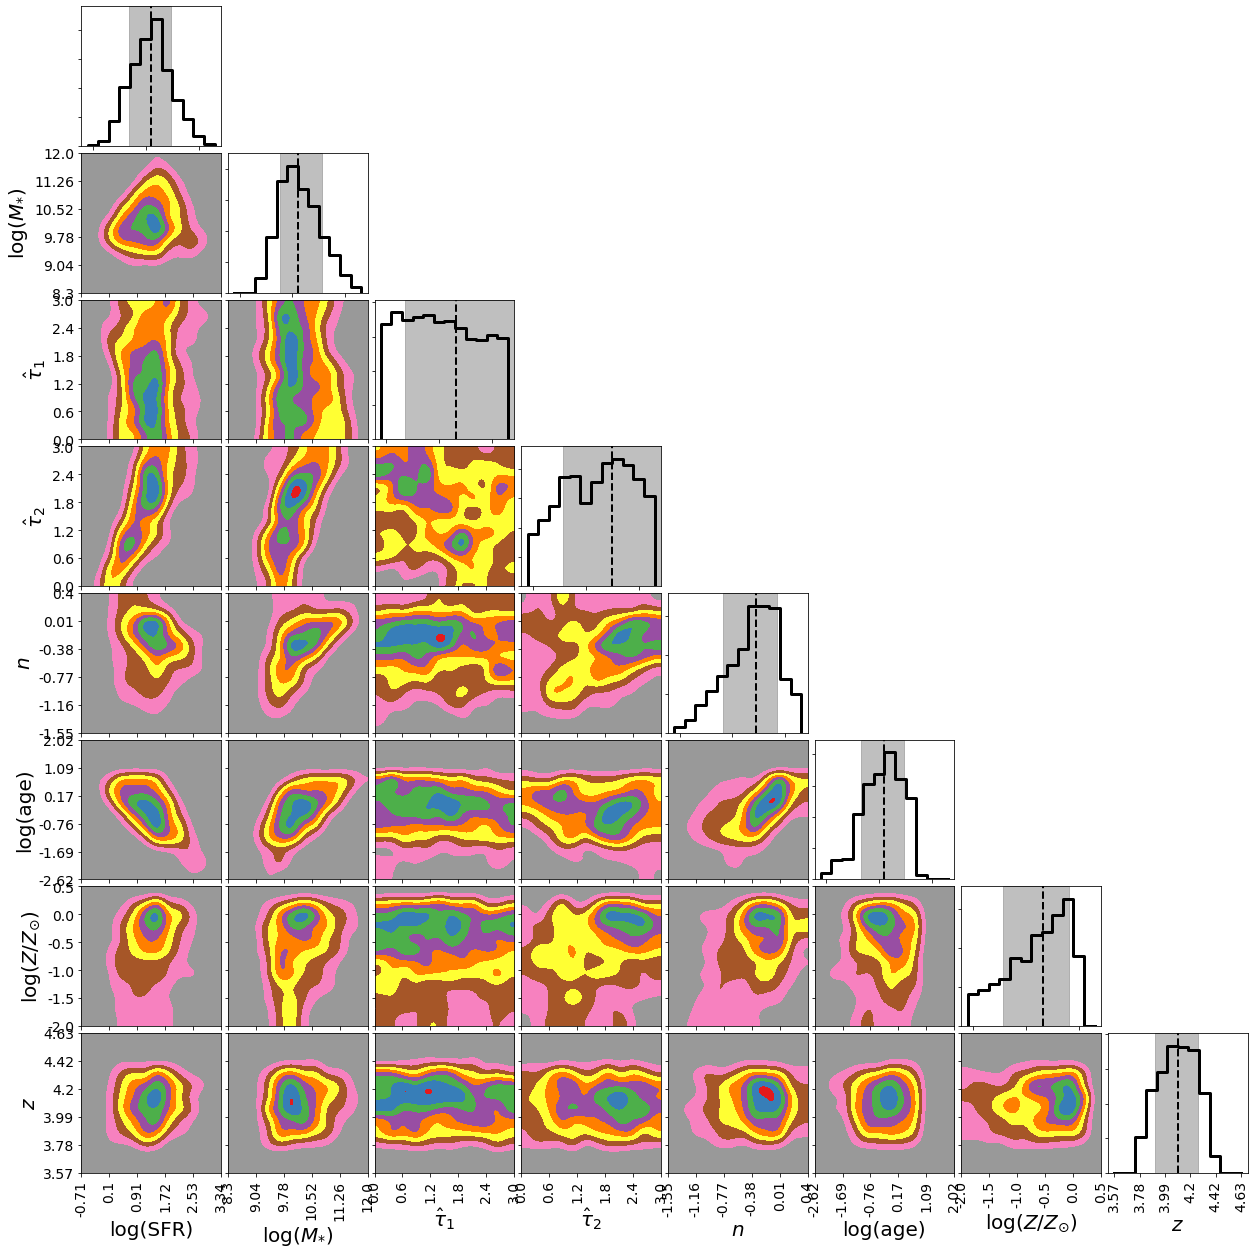

In [47]:
%matplotlib inline

name_sampler_fits = 'mcmc_crop2_33.fits'

params=['log_sfr', 'log_mass',  'dust1', 'dust2', 'dust_index', 'log_mw_age', 'logzsol', 'z']
label_params={'dust1': '$\\hat \\tau_{1}$', 'dust2': '$\\hat \\tau_{2}$', 'dust_index': '$n$', 
              'log_mass': 'log($M_{*}$)', 'log_mw_age': 'log(age)', 'log_sfr': 'log(SFR)', 
              'logzsol': 'log($Z/Z_{\\odot}$)', 'z':'$z$'}

plot_corner(name_sampler_fits, params=params, label_params=label_params)

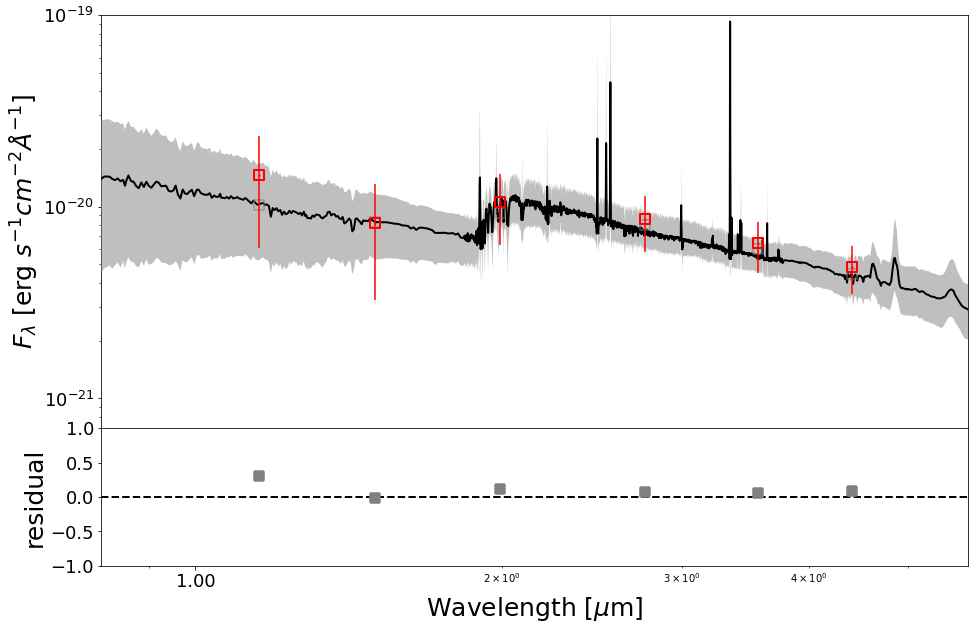

In [48]:
name_sampler_fits = 'mcmc_crop2_33.fits'
plot_SED(name_sampler_fits, decompose=0, yrange=[7e-22,1e-19])

Plotting posteriors probability distributions
=> Number of parameters: 8


'corner_mcmc_crop2_52.png'

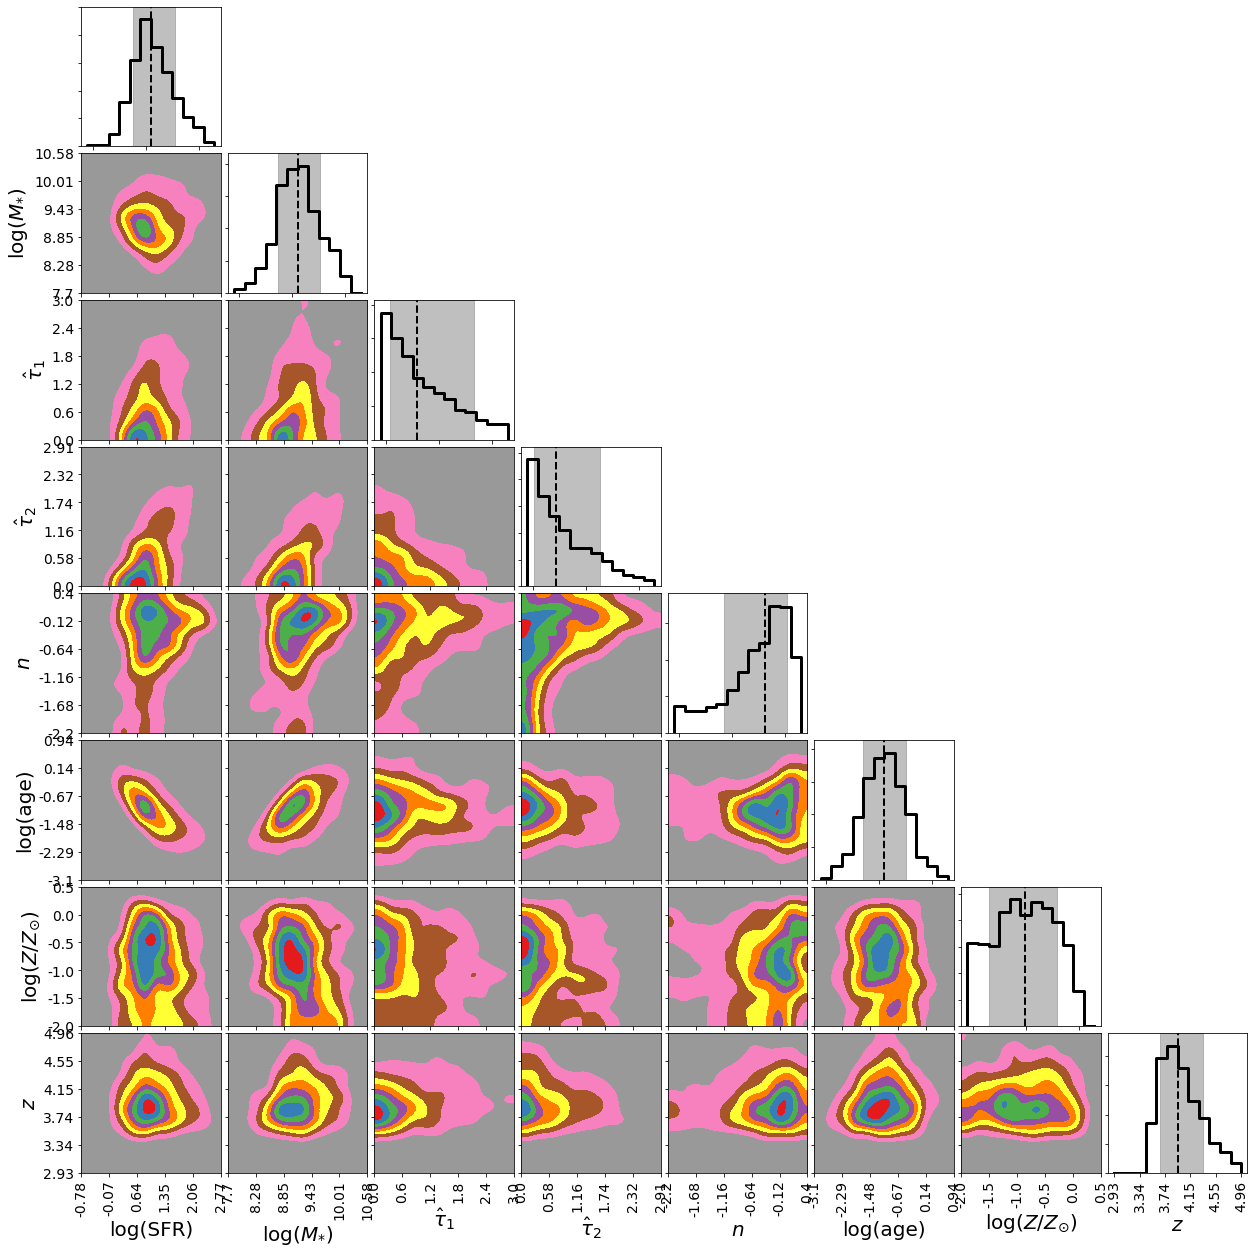

In [7]:
%matplotlib inline

name_sampler_fits = 'mcmc_crop2_52.fits'

params=['log_sfr', 'log_mass',  'dust1', 'dust2', 'dust_index', 'log_mw_age', 'logzsol', 'z']
label_params={'dust1': '$\\hat \\tau_{1}$', 'dust2': '$\\hat \\tau_{2}$', 'dust_index': '$n$', 
              'log_mass': 'log($M_{*}$)', 'log_mw_age': 'log(age)', 'log_sfr': 'log(SFR)', 
              'logzsol': 'log($Z/Z_{\\odot}$)', 'z':'$z$'}

plot_corner(name_sampler_fits, params=params, label_params=label_params)

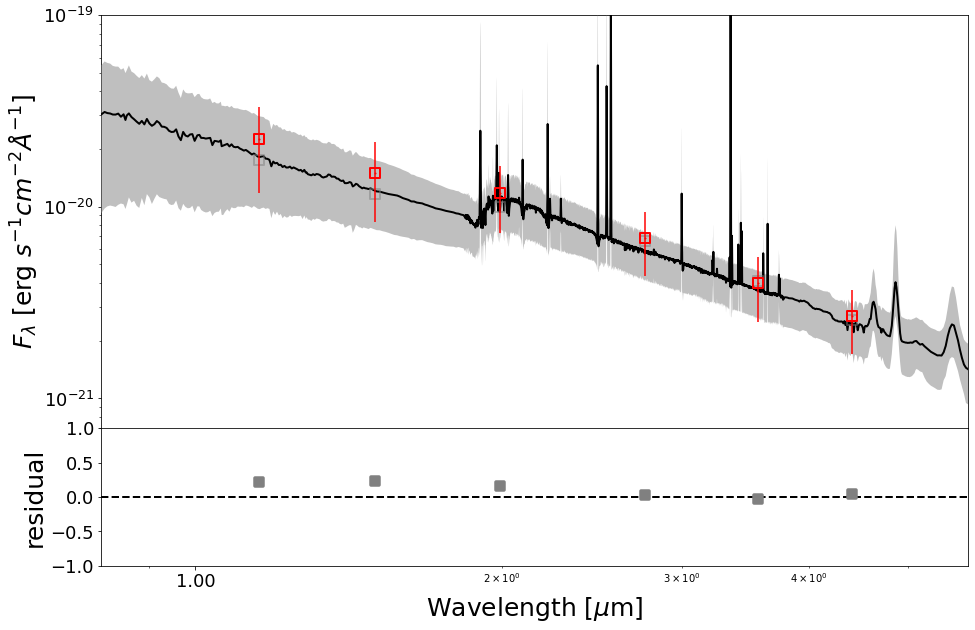

In [11]:
name_sampler_fits = 'mcmc_crop2_52.fits'
plot_SED(name_sampler_fits, decompose=0, yrange=[7e-22,1e-19])

Plotting posteriors probability distributions
=> Number of parameters: 8


'corner_mcmc_crop2_202.png'

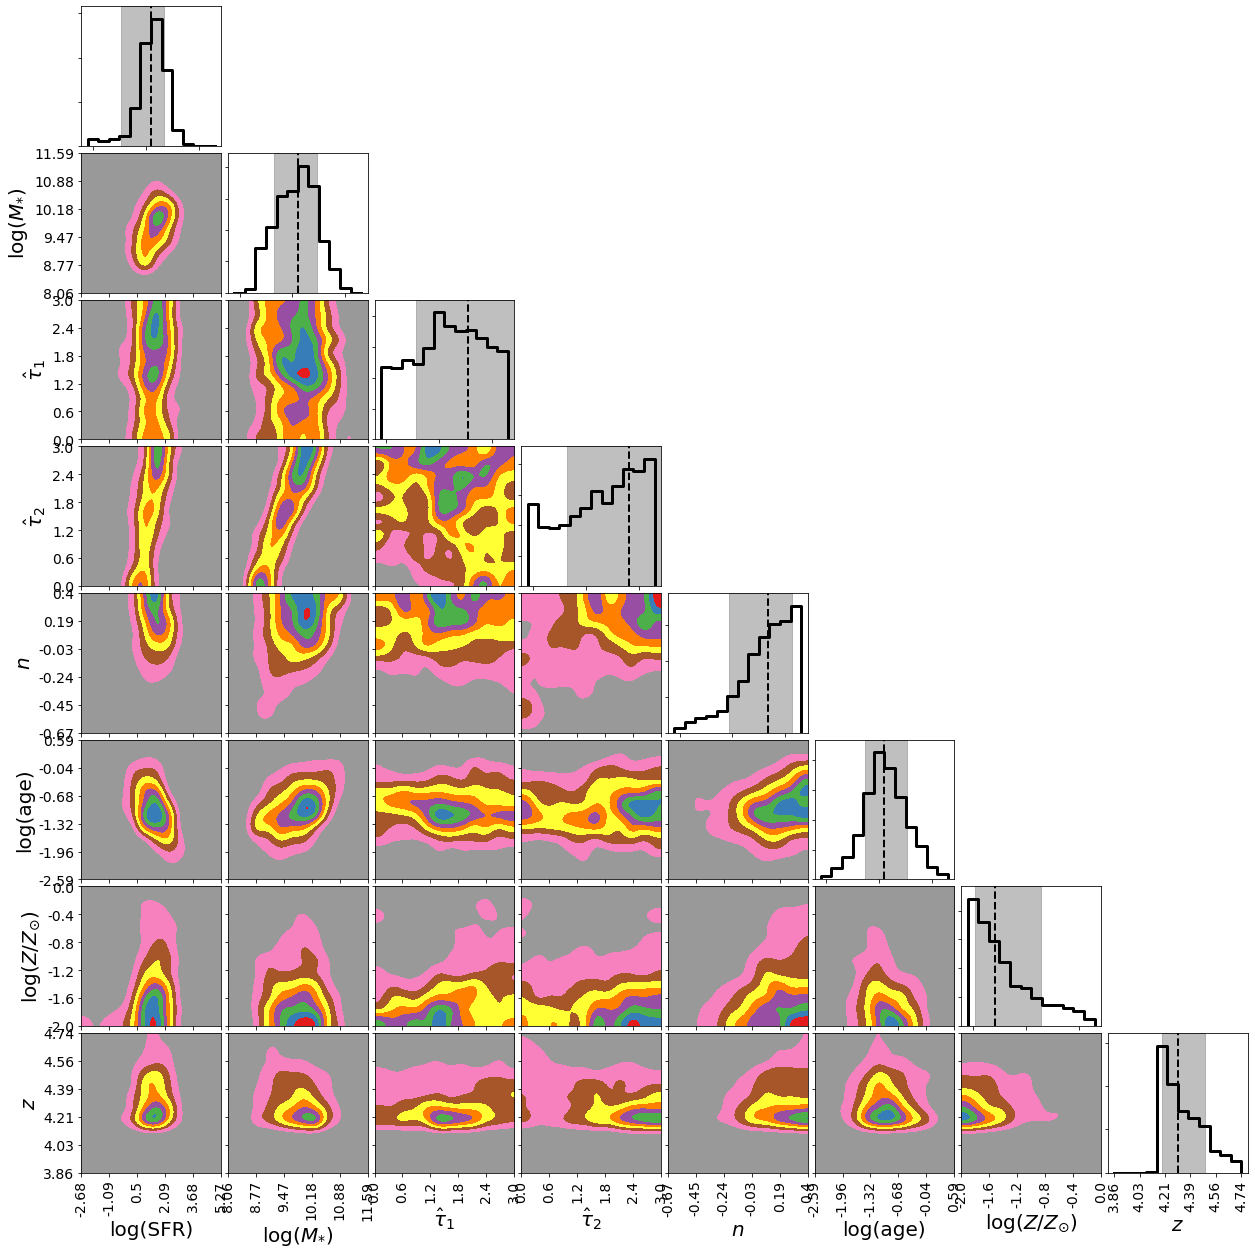

In [51]:
name_sampler_fits = 'mcmc_crop2_202.fits'

params=['log_sfr', 'log_mass',  'dust1', 'dust2', 'dust_index', 'log_mw_age', 'logzsol', 'z']
label_params={'dust1': '$\\hat \\tau_{1}$', 'dust2': '$\\hat \\tau_{2}$', 'dust_index': '$n$', 
              'log_mass': 'log($M_{*}$)', 'log_mw_age': 'log(age)', 'log_sfr': 'log(SFR)', 
              'logzsol': 'log($Z/Z_{\\odot}$)', 'z':'$z$'}

plot_corner(name_sampler_fits, params=params, label_params=label_params)

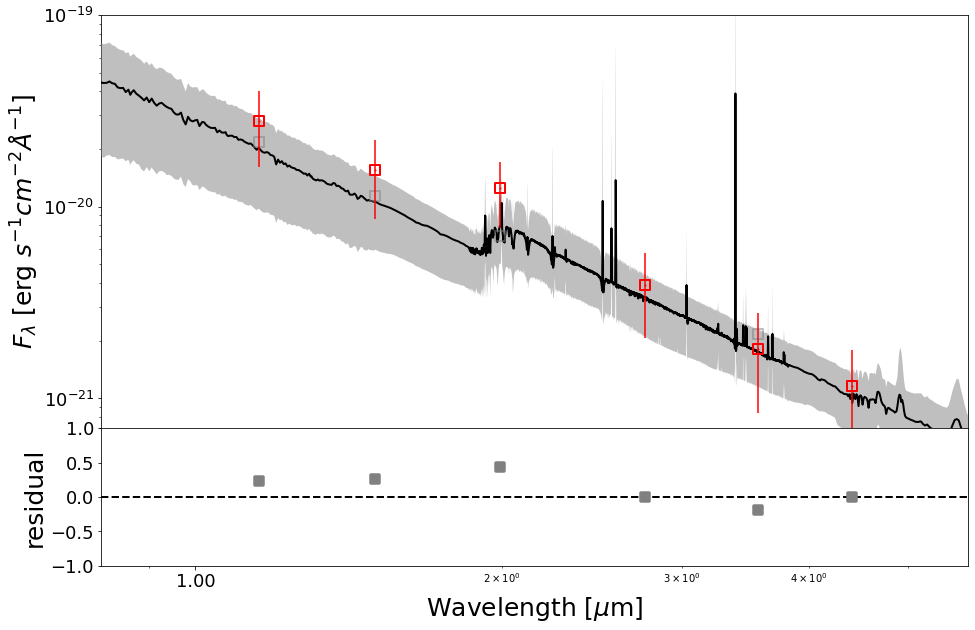

In [52]:
name_sampler_fits = 'mcmc_crop2_202.fits'
plot_SED(name_sampler_fits, decompose=0, yrange=[7e-22,1e-19])

Plotting posteriors probability distributions
=> Number of parameters: 8


'corner_mcmc_crop2_341.png'

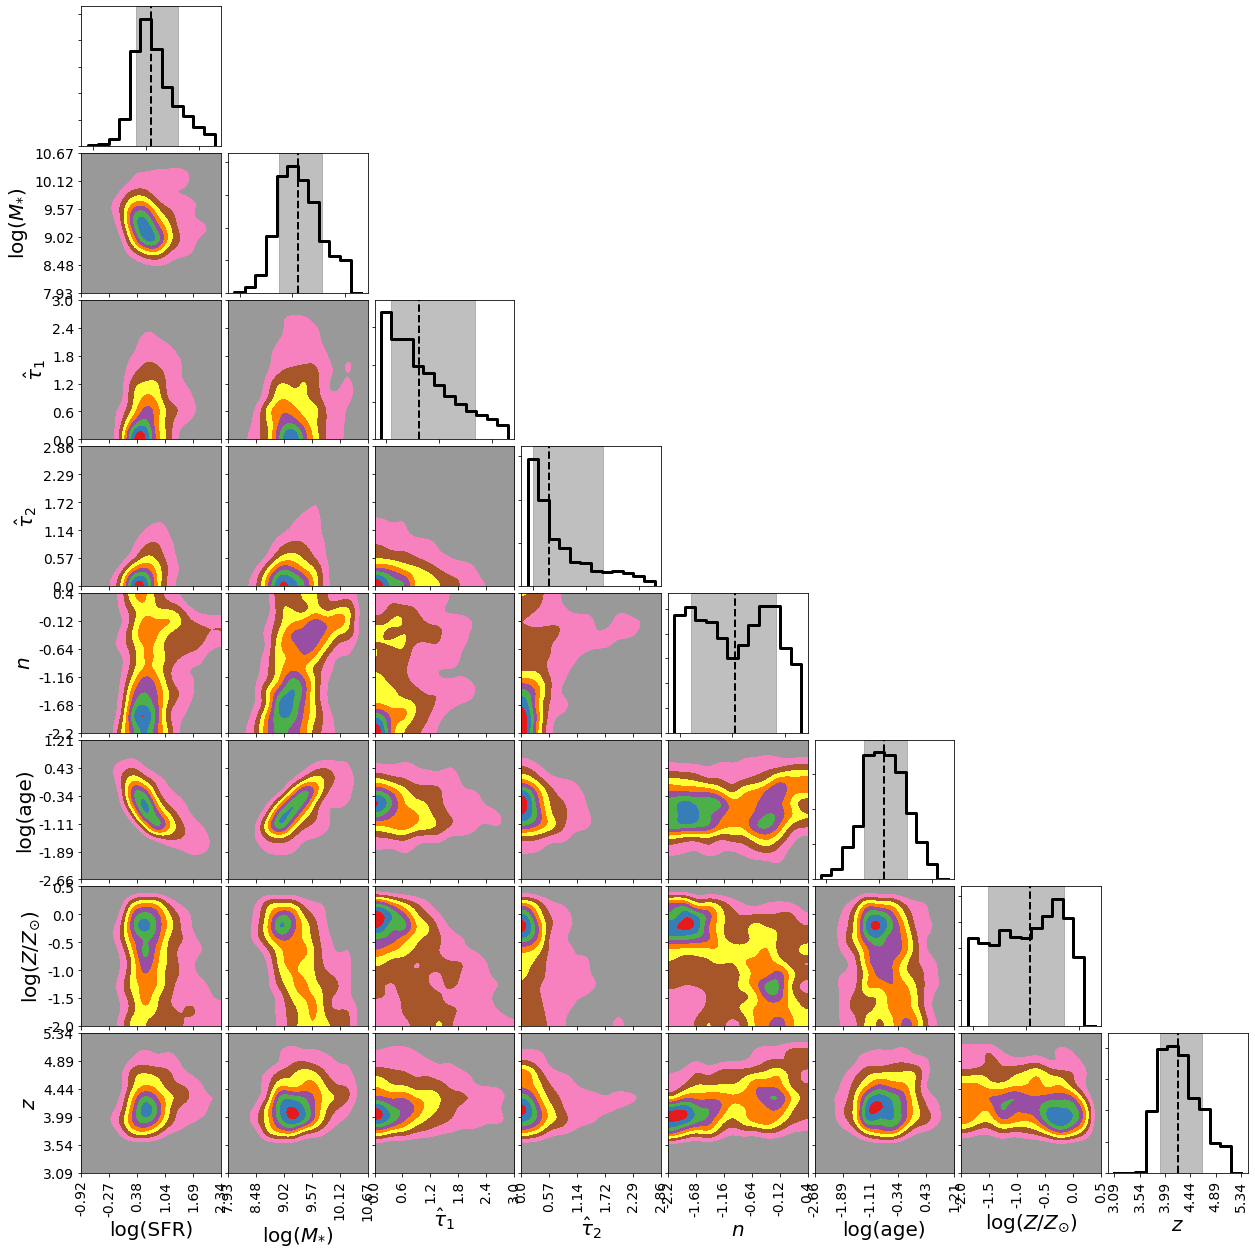

In [9]:
name_sampler_fits = 'mcmc_crop2_341.fits'

params=['log_sfr', 'log_mass',  'dust1', 'dust2', 'dust_index', 'log_mw_age', 'logzsol', 'z']
label_params={'dust1': '$\\hat \\tau_{1}$', 'dust2': '$\\hat \\tau_{2}$', 'dust_index': '$n$', 
              'log_mass': 'log($M_{*}$)', 'log_mw_age': 'log(age)', 'log_sfr': 'log(SFR)', 
              'logzsol': 'log($Z/Z_{\\odot}$)', 'z':'$z$'}

plot_corner(name_sampler_fits, params=params, label_params=label_params)

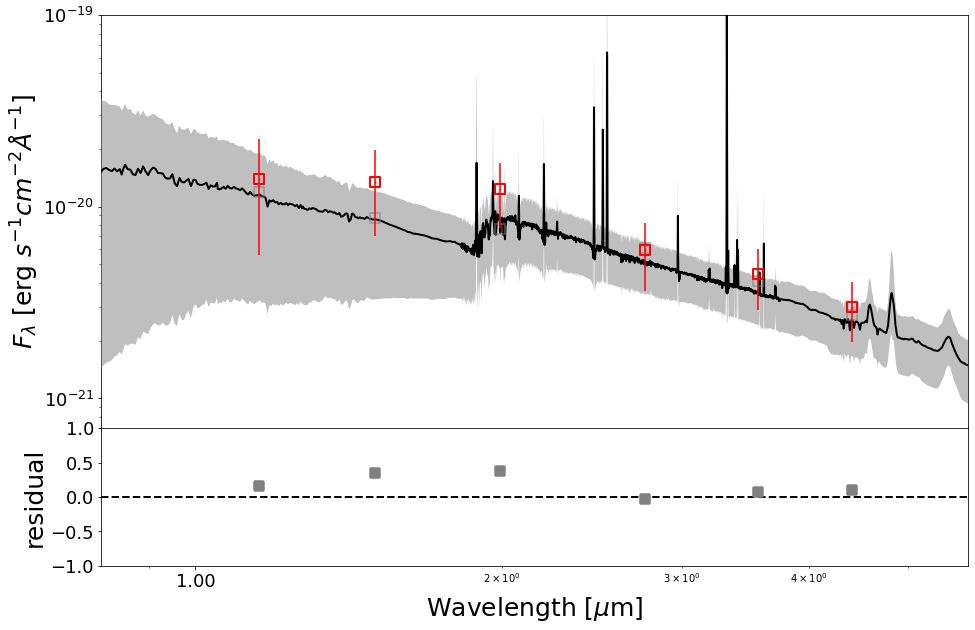

In [12]:
name_sampler_fits = 'mcmc_crop2_341.fits'
plot_SED(name_sampler_fits, decompose=0, yrange=[7e-22,1e-19])

In [59]:
hdu = fits.open('mcmc_crop2_341.fits')
hdu.info()

Filename: mcmc_crop2_341.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   ()      
  1  SAMPLERS      1 BinTableHDU     35   55000R x 13C   [K, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  FIT_PARAMS    1 BinTableHDU     35   3R x 13C   [3A, D, D, D, D, D, D, D, D, D, D, D, D]   
  3  OBS_PHOTO     1 BinTableHDU     13   6R x 2C   [D, D]   
  4  BFIT_PHOTO    1 BinTableHDU     15   6R x 3C   [D, D, D]   
  5  BFIT_MOD_SPEC    1 BinTableHDU     29   5994R x 10C   [D, D, D, D, D, D, D, D, D, D]   


## 4.5. Retrieve Galaxies Properties from SED Fitting Results

### Cropped region 1

In [72]:
from astropy.table import QTable

data = np.loadtxt('ceers_crop1_photo_pz_4z5.cat')
nobj = len(data[:,0])

data_table = []
names = []
names.append('ID')
data_table.append(data[:,0].astype(int))
names.append('x')
data_table.append(data[:,1])
names.append('y')
data_table.append(data[:,2])
names.append('ra')
data_table.append(data[:,3])
names.append('dec')
data_table.append(data[:,4])
  
photo_z = np.zeros(nobj)
logzsol = np.zeros(nobj)
log_mass = np.zeros(nobj)
log_sfr = np.zeros(nobj)
dust1 = np.zeros(nobj)
dust2 = np.zeros(nobj)
log_age = np.zeros(nobj)
for ii in range(0,nobj):
    name = 'mcmc_crop1_%d.fits' % data[ii][0]
    if os.path.exists(name) == True:
        hdu = fits.open(name)
        logzsol[ii] = hdu[2].data['logzsol'][1]
        log_mass[ii] = hdu[2].data['log_mass'][1]
        log_sfr[ii] = hdu[2].data['log_sfr'][1]
        dust1[ii] = hdu[2].data['dust1'][1]*1.086
        dust2[ii] = hdu[2].data['dust2'][1]*1.086
        log_age[ii] = hdu[2].data['log_mw_age'][1]
        photo_z[ii] = hdu[2].data['z'][1]
        hdu.close()
    
names.append('photo-z')
data_table.append(photo_z)
names.append('log(Z/Z_sun)')
data_table.append(logzsol)
names.append('log_mass')
data_table.append(log_mass)
names.append('log_sfr')
data_table.append(log_sfr)
names.append('Av,1')
data_table.append(dust1)
names.append('Av,2')
data_table.append(dust2) 
names.append('log_age')
data_table.append(log_age)
    
names = tuple(names)
t = QTable(data_table, names=names, meta={'name': 'sed_fits'})

In [73]:
t

<QTable length=36>
  ID     x        y        ra      dec         photo-z           log(Z/Z_sun)          log_mass            log_sfr              Av,1                Av,2              log_age      
int64 float64  float64  float64  float64       float64             float64             float64             float64            float64             float64             float64      
----- -------- -------- -------- -------- ------------------ -------------------- ------------------ ------------------- ------------------ ------------------- -------------------
    1 1329.709 15.90736 214.9619 52.90426  4.342678479811898  -1.3667291314033574  8.609369399322997  0.3133856681324286  2.655538718295908   0.514054350129553  -1.025374193741892
   52 1038.644 298.3663 214.9622 52.90089  4.690534855348979 -0.48054025144152024  9.500337371982205 0.49808223947030195 2.6810547874492894  0.8835444300195321 -0.2791689426082441
   53 1364.629 282.4081  214.965 52.90303  4.863838049980329  -1.5030099498914735  8.721962241475465 0.10203655578360943 2.7362147020363685  0.7696162895049168 -0.7889953356605544
   60 769.7474 331.5955 214.9601 52.89902 4.8531920231547385 -0.21960188697659813  8.727051043999314  0.5834763892627962 0.9786652536030108  2.7475647951010007 -1.0097629024087023
   72  1121.98 372.5254 214.9638 52.90101  4.132271569996738  -0.3290860781141652  9.035438522903915  0.7192699668560809 2.5062296256247447   2.008074776993423 -0.9943255098864824
   76 139.3723 382.5875  214.955 52.89477 4.3914100649012635   -1.459418598247919  8.951020707219143  0.5234660676659766 2.4454686046981022  0.5284535890783549 -0.8714344730731198
   77 297.4719 384.1984 214.9564 52.89576  4.390996347916882  -1.4540703721996207  8.721598289534024  0.5424178737777428 2.9236750144457795 0.43109013464356055 -1.0938754468683636
   82 1463.249 410.6211 214.9672 52.90295  4.835292164315786  -0.5068907086509277   9.13237722868433    1.26735577385505 1.1343440039726003  2.8266459714043752 -1.3003089976573081
   95 922.6574  489.415 214.9632 52.89912  4.011905448570035  -1.1019688765684494  9.088842875177805  0.8896032718495641 2.9866028026565132   0.690760617392405 -1.1009484686461717
  100 1953.731 510.5495 214.9727 52.90549  4.424714158615423  -0.4104167739754323 10.235857217790086  2.0933923258546416  2.761467410177532   2.120754860037924 -1.0910484696988831
  114 335.1701 549.2202 214.9585 52.89509  4.226462403533965   -1.546505161265983  9.084123169618909  0.6683536769624082 2.4595376314291033  0.6691121136736816 -0.8429372015352484
  118 128.2713   570.48 214.9568 52.89367  4.738899166826135  -1.2738686801322623  8.834199078532802  0.5416264339463004  2.508003620731691  0.9658038003538979 -1.0968840337142998
  123 335.2425 590.9125 214.9589 52.89487  5.007252278134264  -1.4823958105734047   8.48294309030877  0.7999310005340289 0.7384168106820483  2.0497042466366193 -1.3662468863459896
  131 118.4956 619.3908 214.9572 52.89334    4.7433299202375  -1.2599850635359955   8.88266290495655  0.7424146145713807  2.382366327934133  1.0436369821880653 -1.2023959347309798
  132 829.7976  626.842 214.9638 52.89778  4.179605897073337  -1.4597918367390559  9.287205768342767  0.9106457288247625 2.7053363475767744  0.7434577857276333 -0.9145587154423015
  150 488.8289 731.5356 214.9618 52.89506  4.042661218600986   -1.450930432856187  8.880567548776142  0.6486616041983189  2.652528143051068  0.6529562057238092 -1.0447197370256198
  180 1880.665 845.9434 214.9756 52.90319  4.421927417100204  -1.4512718430143254   8.79134056464612  0.5665403607455434  2.966357240110261  0.8781945733405275  -1.078527758981013
  181 1442.827 847.8395 214.9716 52.90043  4.179087782529996  -1.2020215827139251   8.88526072061804  0.7662062870431889  2.680517999234306   0.562234866531378 -1.0334747804146318
  214 121.5867 1032.724 214.9616 52.89111  4.809901968523972   -1.239564384960861  8.644432725208915  0.2672929394227941  2.485410388466497  0.6594487740801493 -0.9869316864670431
  243 576.3797 1158.7

## Cropped region 2

In [74]:
from astropy.table import QTable

data = np.loadtxt('ceers_crop2_photo_pz_4z5.cat')
nobj = len(data[:,0])

data_table = []
names = []
names.append('ID')
data_table.append(data[:,0].astype(int))
names.append('x')
data_table.append(data[:,1])
names.append('y')
data_table.append(data[:,2])
names.append('ra')
data_table.append(data[:,3])
names.append('dec')
data_table.append(data[:,4])
    
photo_z = np.zeros(nobj)
logzsol = np.zeros(nobj)
log_mass = np.zeros(nobj)
log_sfr = np.zeros(nobj)
dust1 = np.zeros(nobj)
dust2 = np.zeros(nobj)
log_age = np.zeros(nobj)
for ii in range(0,nobj):
    name = 'mcmc_crop2_%d.fits' % data[ii][0]
    if os.path.exists(name) == True:
        hdu = fits.open(name)
        logzsol[ii] = hdu[2].data['logzsol'][1]
        log_mass[ii] = hdu[2].data['log_mass'][1]
        log_sfr[ii] = hdu[2].data['log_sfr'][1]
        dust1[ii] = hdu[2].data['dust1'][1]*1.086
        dust2[ii] = hdu[2].data['dust2'][1]*1.086
        log_age[ii] = hdu[2].data['log_mw_age'][1]
        photo_z[ii] = hdu[2].data['z'][1]
        hdu.close()
    
names.append('photo-z')
data_table.append(photo_z)
names.append('log(Z/Z_sun)')
data_table.append(logzsol)
names.append('log_mass')
data_table.append(log_mass)
names.append('log_sfr')
data_table.append(log_sfr)
names.append('Av,1')
data_table.append(dust1)
names.append('Av,2')
data_table.append(dust2) 
names.append('log_age')
data_table.append(log_age)
    
names = tuple(names)
t = QTable(data_table, names=names, meta={'name': 'sed_fits'})

In [75]:
t

<QTable length=34>
  ID     x        y        ra      dec         photo-z           log(Z/Z_sun)         log_mass           log_sfr              Av,1               Av,2              log_age      
int64 float64  float64  float64  float64       float64             float64            float64            float64            float64            float64             float64      
----- -------- -------- -------- -------- ------------------ ------------------- ----------------- ------------------- ------------------ ------------------ -------------------
   33 764.8459 145.4218 214.9779 52.91372  4.098934387288465 -0.5200299381620412 10.15095830990223  1.3152951844355043  1.937818060596343   2.17162781267793 -0.2958719950751103
   36 156.6565   148.72 214.9724 52.90987 3.9614998872888894 -1.4076664518119484 8.877480301748665  0.6290872507607667  2.743107962343567 0.5239997595350703 -1.0723902073712213
   37 873.8169 156.9852  214.979 52.91434  4.674994332601417 -0.9669398455223843  9.42769226742613    0.82468430065559 2.6441223083473178 0.7432957881664105 -0.7302842767765052
   39 1152.266 161.1124 214.9816 52.91607  4.317281184648146  -1.462236782868166 9.030160300123795   1.007316947307169 2.7233988658493518 0.4711223120365383 -1.2025827670828761
   43 1719.226 179.2613 214.9869 52.91954   4.66814741460507 -0.3560031948113205  9.53977857128379   1.136835684552156  2.554947581342771 2.6293764937707502 -1.0003991476675884
   52  718.256 228.1529 214.9783 52.91297   4.23588202148204 -1.5117706436702176 9.382553038132375  0.8575233033467851  1.563094792540097 0.6317839622776263 -0.9264816400246673
   60 330.3159 254.0283 214.9751 52.91039  4.525335717178697 -0.9587111452362265 9.114790429719534  0.6498753405291733 0.8118442766051612 2.5170827372562736 -0.9325923780238475
  133 490.4704 510.3542 214.9792    52.91  4.497640432869481 -0.5001506341174773 8.968779674356643  1.1542914635896113 2.5850617606174304 0.7914949408068421 -1.3074279257643642
  166 1542.323 656.5549 214.9903 52.91581  4.535501229452468 -1.3316467024198213 8.952373275165398  0.5600281830074922 2.1626101249858567 0.6204482165555191 -0.9684548819279661
  178 1485.849 722.0898 214.9905  52.9151 4.7550087060749195  -1.443129378196689 9.145100043446782  0.8296905145024669  2.897104890049685 0.4987931308710957  -1.001273952144051
  189 399.6385  783.517 214.9813 52.90793  4.530242945138486 -1.1107028239594963 8.850674299702627  0.7266363538671321  2.320302903756416 0.7465488344816347 -1.1182463555278277
  202 1967.253 911.9432 214.9968 52.91709  4.293316260690256 -1.5593113070979554 9.834693797786116  1.2550963420283114  2.233686308958319 2.6155829809139806 -0.9752469578620334
  241 1900.088 1067.726 214.9978 52.91582  4.042943612840808 -0.3038652273954956 9.083124501922775  0.9262948595130178 3.1271535119201634 1.0752741876399614 -1.0986726034570327
  243 849.7716 1076.287 214.9884 52.90916   4.35127247684779 -1.5014921582136866 9.054956381882015  0.6607234934702458 2.7523533606896793 0.6242589048499443  -0.897670760491923
  279 1143.987 1135.871 214.9917 52.91069  4.635190024285654 -1.4699262557597024 8.977557209042592  0.6181001883467974 2.8325085010437467 0.7225764616433588  -1.000259858351269
  289 1479.962 1202.846 214.9954 52.91243  4.044756316307716 -1.3724281063123218  8.96233400231088  0.6251249925701463 2.4312065150883586 0.6689554161778275 -0.9863788986012545
  313 1071.486 1322.106  214.993 52.90921  4.619883946694863  -1.206465428484077 9.825201879075726  1.3370390645730883  2.794563492228577 0.5379880380543888 -0.7904973514362192
  316 1733.529 1324.388  214.999 52.91336  4.703596944816121 -0.8017359169265705  9.04299188600843   1.122215659439095 1.1140989038840072  3.013143604388735   -1.14227215509511
  331 1402.258 1390.256 214.9967 52.91092  4.083703500394441 -1.4837112019235614 9.811352089535246  0.8903468170809137 1.4365601598884985 2.7578914271379737 -0.6132393118807393
  334  1336.74 1414.136 214.9963 52.91038 3.9627090159883647 -0.9465255260443979 8.6652

## 4.6. Look at the galaxies

## Cropped region 1

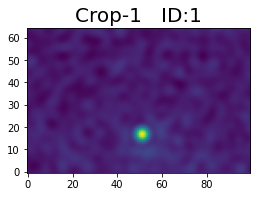

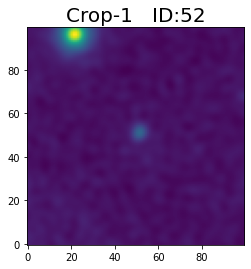

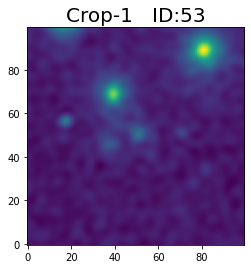

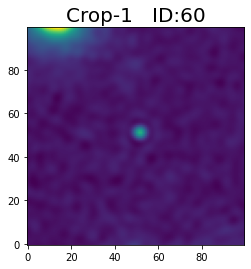

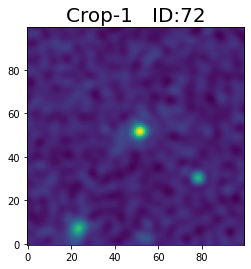

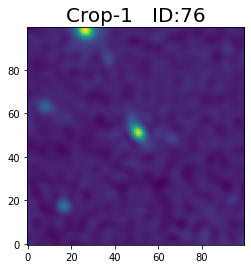

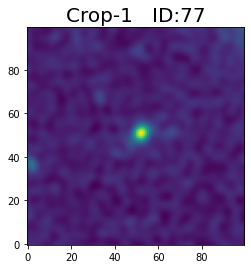

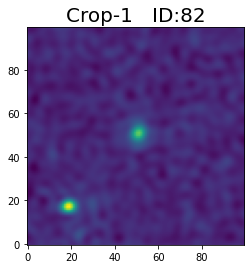

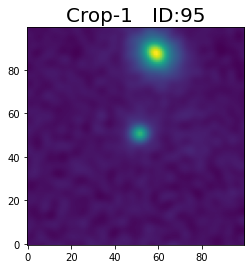

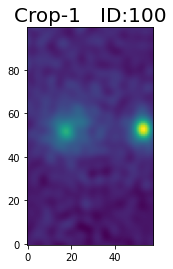

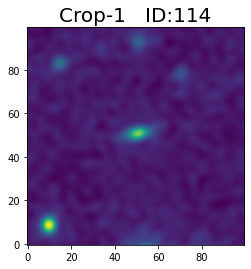

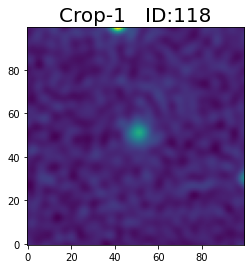

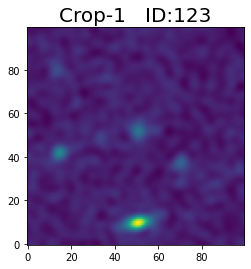

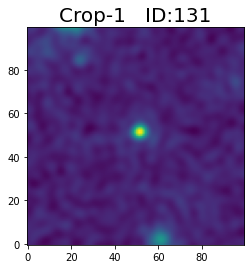

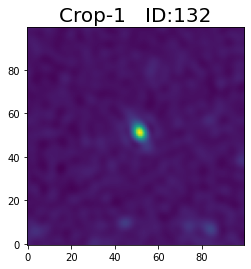

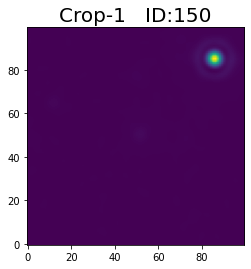

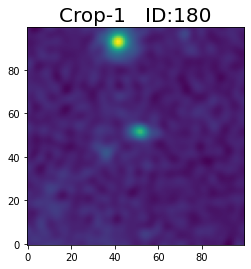

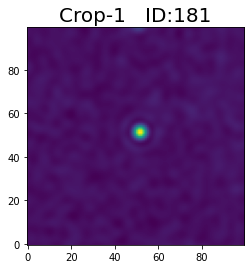

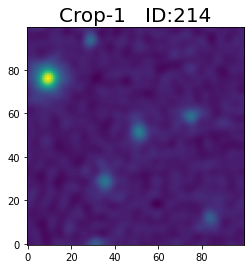

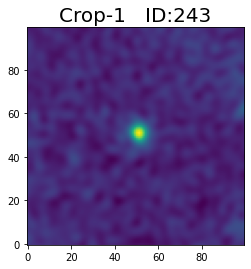

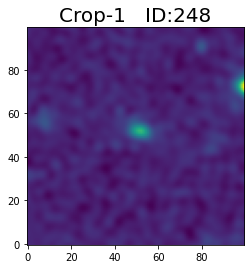

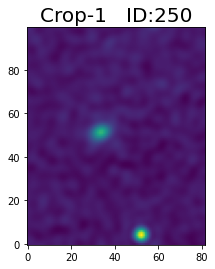

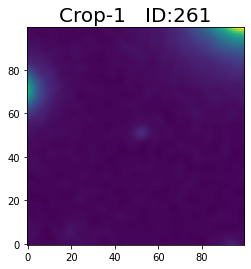

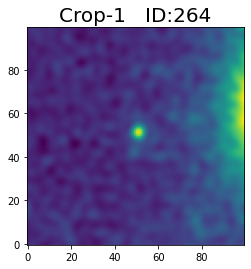

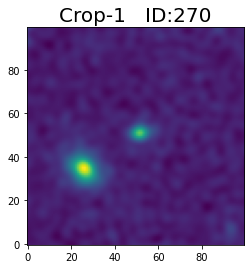

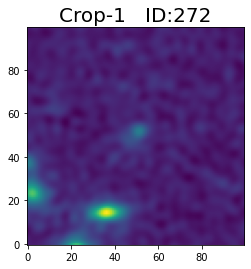

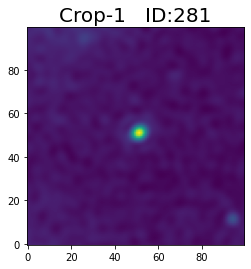

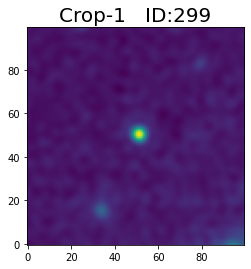

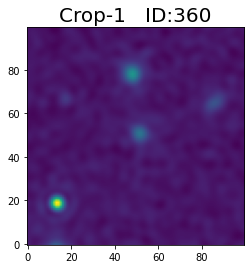

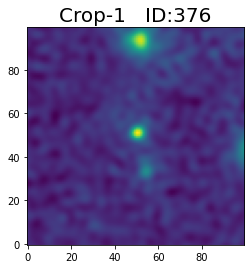

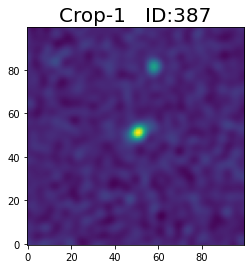

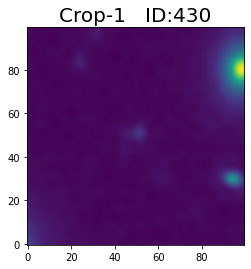

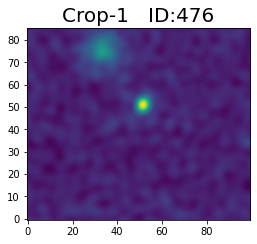

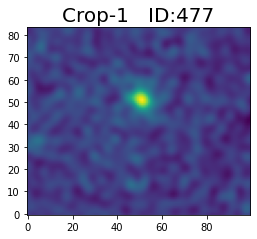

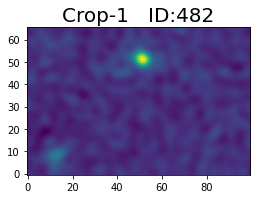

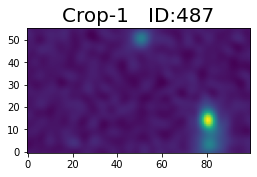

In [54]:
data = np.loadtxt('ceers_crop1_photo_pz_4z5.cat')

hdu = fits.open('../psfmatch_crop1_ceers5_f200w_sci.fits.gz')
data_img = hdu[0].data
hdu.close()

dim_y, dim_x = data_img.shape[0], data_img.shape[1]

for ii in range(0,len(data[:,0])):
    x_cent, y_cent = int(data[ii][1]), int(data[ii][2])
    
    xmin, xmax = x_cent-50, x_cent+50
    ymin, ymax = y_cent-50, y_cent+50
    if xmin<0:
        xmin = 0
    if xmax>dim_x:
        xmax = dim_x
    if ymin<0:
        ymin = 0
    if ymax>dim_y:
        ymax = dim_y
        
    data_img_crop = data_img[ymin:ymax, xmin:xmax]
    
    fig = plt.figure(figsize=(4,4))
    f1 = plt.subplot()
    plt.title("Crop-1   ID:%d" % data[ii][0], fontsize=20)
    plt.imshow(data_img_crop, origin='lower')


## Cropped region 2

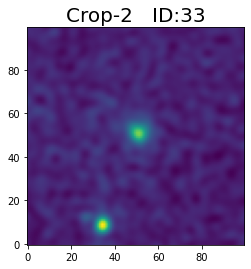

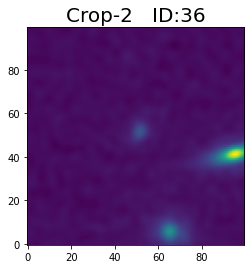

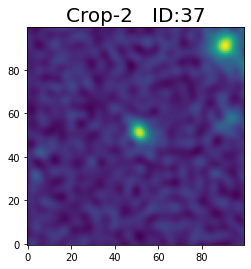

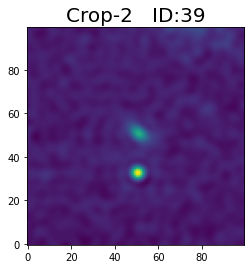

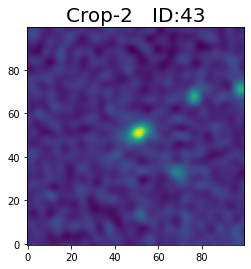

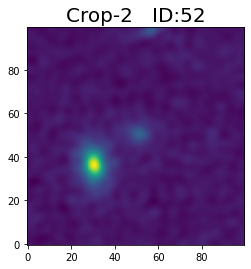

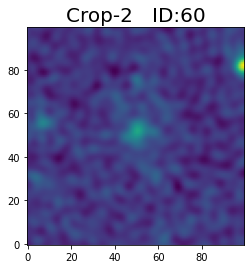

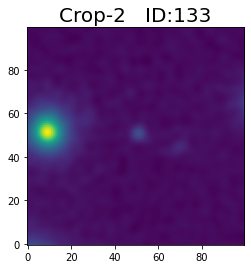

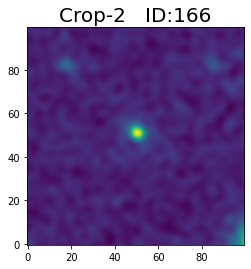

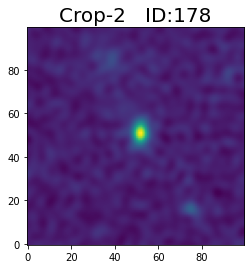

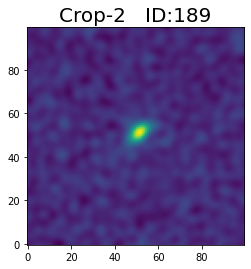

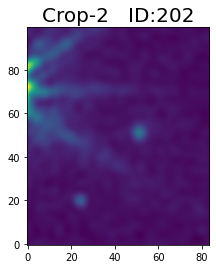

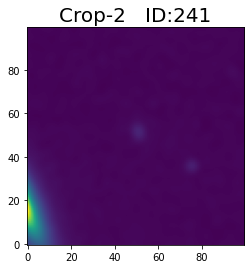

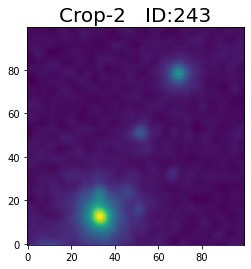

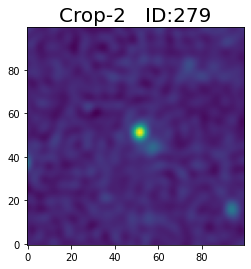

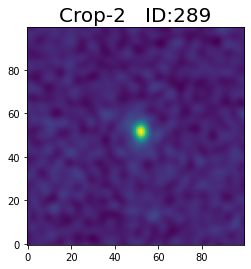

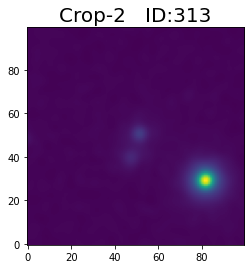

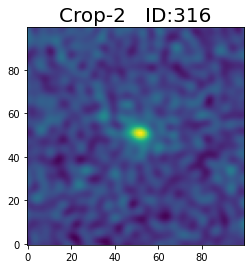

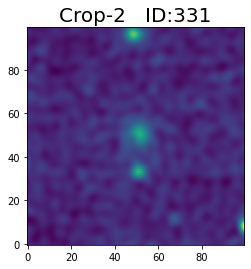

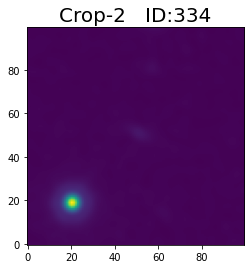

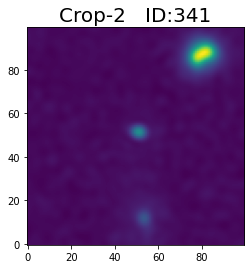

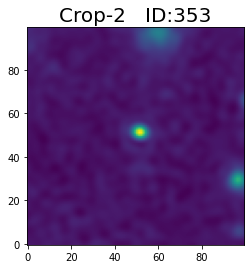

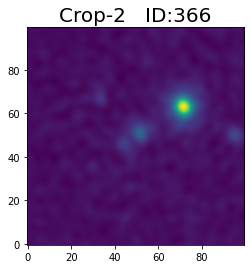

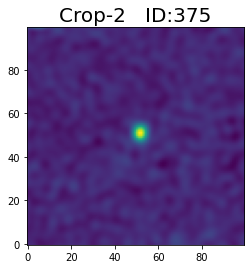

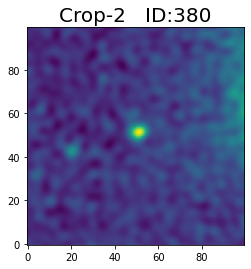

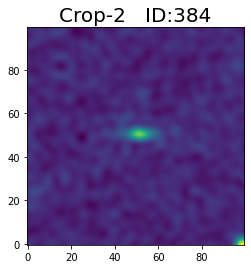

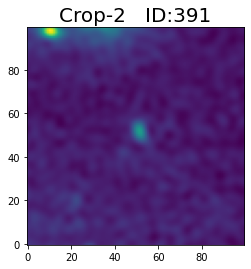

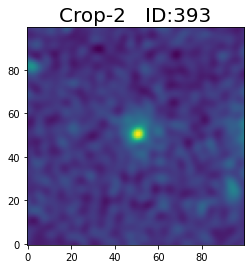

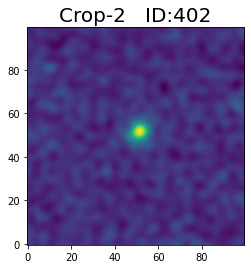

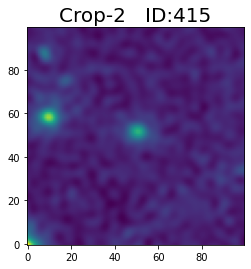

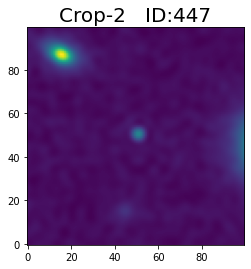

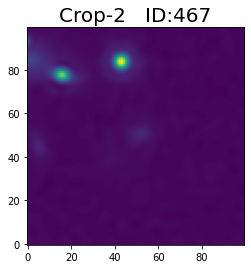

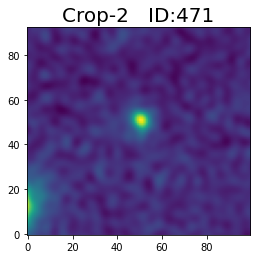

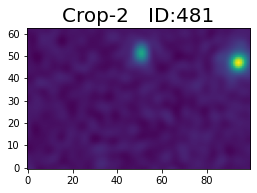

In [55]:
data = np.loadtxt('ceers_crop2_photo_pz_4z5.cat')

hdu = fits.open('../psfmatch_crop2_ceers5_f200w_sci.fits.gz')
data_img = hdu[0].data
hdu.close()

dim_y, dim_x = data_img.shape[0], data_img.shape[1]

for ii in range(0,len(data[:,0])):
    x_cent, y_cent = int(data[ii][1]), int(data[ii][2])
    
    xmin, xmax = x_cent-50, x_cent+50
    ymin, ymax = y_cent-50, y_cent+50
    if xmin<0:
        xmin = 0
    if xmax>dim_x:
        xmax = dim_x
    if ymin<0:
        ymin = 0
    if ymax>dim_y:
        ymax = dim_y
        
    data_img_crop = data_img[ymin:ymax, xmin:xmax]
    
    fig = plt.figure(figsize=(4,4))
    f1 = plt.subplot()
    plt.title("Crop-2   ID:%d" % data[ii][0], fontsize=20)
    plt.imshow(data_img_crop, origin='lower')